In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report
from imutils import paths
import random 
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
initial_learning_rate = 1e-4
eps = 20
batch = 32

In [3]:
categories = ['WithMask', 'WithoutMask']

In [4]:
Xt = []
Yt = []
Xv = []
Yv = []
Xte = []
Yte = []

In [5]:
pathGeneral = os.path.join(os.getcwd(),'Face Mask Dataset')
pathTrain = [os.path.join(pathGeneral,'Train'), Xt, Yt]
pathValid = [os.path.join(pathGeneral,'Validation'), Xv, Yv] 
pathTest = [os.path.join(pathGeneral,'Test'), Xte, Yte]
paths = [pathTrain, pathValid, pathTest]

In [6]:
img_size = 250

for path in paths:
    for c in categories:
        folder = os.path.join(path[0],c)
        for img in os.listdir(folder):
            img_path = os.path.join(folder, img)
            image = load_img(img_path, target_size = (224,224))
            image = img_to_array(image)
            image = preprocess_input(image)
            path[1].append(image)
            path[2].append(c)
        

In [7]:
Xtrain = Xt
Ytrain = Yt
Xvalid = Xv
Yvalid = Yv
Xtest = Xte
Ytest = Yte

In [8]:
lb = LabelBinarizer()
Ytrain = lb.fit_transform(Ytrain)
Yvalid = lb.fit_transform(Yvalid)
Ytest = lb.fit_transform(Ytest)
Ytrain = to_categorical(Ytrain)
Yvalid = to_categorical(Yvalid)
Ytest = to_categorical(Ytest)

In [9]:
Xtrain = np.array(Xtrain)
Ytrain = np.array(Ytrain)
Xvalid = np.array(Xvalid)
Yvalid = np.array(Yvalid)
Xtest = np.array(Xtest)
Ytest = np.array(Ytest)

In [10]:
baseModel = MobileNetV2(weights = 'imagenet', include_top = False, 
                        input_tensor = Input(shape = (224, 224, 3)))

In [11]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (7,7))(headModel)
headModel = Flatten(name = 'flatten')(headModel)
headModel = Dense(128, activation = 'relu')(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation = 'softmax')(headModel)

In [12]:
model = Model(inputs = baseModel.input, outputs = headModel)

In [13]:
for layer in baseModel.layers:
    layer.trainable = False

In [14]:
opt = Adam(learning_rate = initial_learning_rate, decay = initial_learning_rate / eps)

In [15]:
model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [16]:
callbacks = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')

In [17]:
h = model.fit(
    Xtrain,
    Ytrain,
    steps_per_epoch = len(Xtrain) // batch,
    validation_data = (Xvalid, Yvalid),
    validation_steps = len(Xvalid) // batch,
    callbacks = [callbacks],
    epochs = eps)
    


Epoch 1/20
312/312 [==============================] - 209s 647ms/step - loss: 0.1555 - accuracy: 0.9489 - val_loss: 0.0395 - val_accuracy: 0.9937
Epoch 2/20
312/312 [==============================] - 197s 633ms/step - loss: 0.0402 - accuracy: 0.9889 - val_loss: 0.0246 - val_accuracy: 0.9950
Epoch 3/20
312/312 [==============================] - 194s 622ms/step - loss: 0.0257 - accuracy: 0.9930 - val_loss: 0.0212 - val_accuracy: 0.9962
Epoch 4/20
312/312 [==============================] - 194s 621ms/step - loss: 0.0210 - accuracy: 0.9937 - val_loss: 0.0162 - val_accuracy: 0.9962
Epoch 5/20
312/312 [==============================] - 195s 624ms/step - loss: 0.0152 - accuracy: 0.9952 - val_loss: 0.0141 - val_accuracy: 0.9950
Epoch 6/20
312/312 [==============================] - 200s 641ms/step - loss: 0.0134 - accuracy: 0.9959 - val_loss: 0.0133 - val_accuracy: 0.9962
Epoch 7/20
312/312 [==============================] - 217s 697ms/step - loss: 0.0115 - accuracy: 0.9968 - val_loss: 0.0119 -

In [18]:
predIdxs = model.predict(Xvalid, batch_size=batch)

25/25 [==============================] - 15s 558ms/step


In [19]:
predIdxs = np.argmax(predIdxs, axis=1)

In [20]:
print(classification_report(Yvalid.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       400
 WithoutMask       1.00      0.99      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [21]:
model.save("mask_detector.model", save_format="h5")

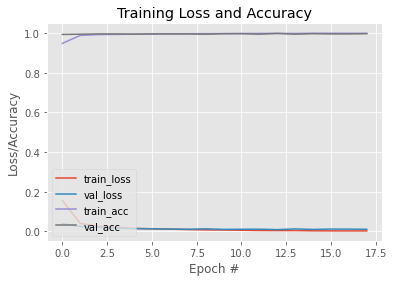

In [23]:
N = 18
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), h.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), h.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), h.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), h.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [24]:
prediction = model.predict(Xtest)

31/31 [==============================] - 17s 551ms/step


In [25]:
prediction = np.argmax(prediction, axis = 1)

In [26]:
Ytest = np.argmax(Ytest, axis = 1)

In [51]:
correctPredictions = 0

for i in range(len(prediction)):
    if (prediction [i] == Ytest [i]):
        correctPredictions +=1
        

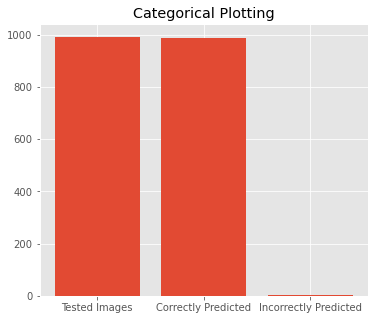

Number of tested images:  992
Number of correct predictions:  988
Number of incorrect predictions:  4
Accuracy:  99.59677419354838 %


In [53]:
names = ['Tested Images', 'Correctly Predicted', 'Incorrectly Predicted']
values = [len(Ytest), correctPredictions, len(prediction) - correctPredictions]
plt.figure(figsize=(20, 5))
plt.subplot(131)
plt.bar(names, values)
plt.title('Categorical Plotting')
plt.show()
print('Number of tested images: ', len(Ytest))
        
print('Number of correct predictions: ', correctPredictions)

print('Number of incorrect predictions: ', len(prediction) - correctPredictions)

print('Accuracy: ', (correctPredictions / len(prediction)* 100), '%')

C:\Users\User\AppData\Local\Temp/ipykernel_11744/3586831639.py:1: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(Ytest, 'ro', color = 'blue')
C:\Users\User\AppData\Local\Temp/ipykernel_11744/3586831639.py:2: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(prediction, 'ro', color = 'yellow', label = 'Prediction')


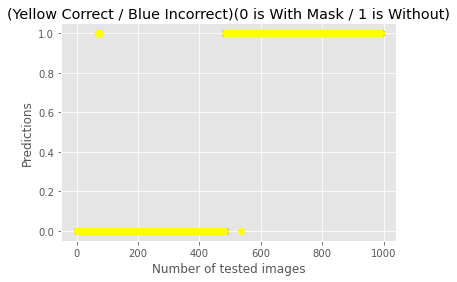

In [54]:
plt.plot(Ytest, 'ro', color = 'blue')
plt.plot(prediction, 'ro', color = 'yellow', label = 'Prediction')
plt.title('(Yellow Correct / Blue Incorrect)(0 is With Mask / 1 is Without)')
plt.xlabel('Number of tested images')
plt.ylabel('Predictions')
plt.show()
